In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['Womens Clothing E-Commerce Reviews.csv']


## Searching for Insights in Feedback Text

This kernel forms part of my final project for my Udacity Machine Learning Engineer Nanodegree. I'm very grateful to Nick for providing this data which was a rich set to work on. Hopefully the code and conclusions show some good insights into the data.

I have directly used techniques outlined in the following article by Alex Loveless:
http://alexloveless.co.uk/data/chinese-whispers-graph-clustering-in-python/

which builds on the original paper:

“Chinese Whispers. Chris Biemann, University of Leipzig.” 

https://pdfs.semanticscholar.org/c64b/9ed6a42b93a24316c7d1d6b3fddbd96dbaf5.pdf?_ga=2.230952607.1829690988.1547582204-522992221.1547582204

**Problem Statement**

Can insights that are useful to the retailer outside of the rating and recommendations be
found in text reviews? Can patterns be established that could be used to follow up with
certain customer groups or even for redesigning clothes?

**Solution**

My proposed solution is to use an unsupervised model, with the goal to cluster reviews with similar meaning. I plan to try graph clustering with the Chinese Whispers algorithm, using text vectors from Gensim Word2Vec.

This should reveal categories of comments that multiple customers have written based on the language they have used themselves, rather than arbitrary categories chosen prior to analysis.

## Initial Analysis

Let's see what we've got.

In [2]:
raw_data = pd.read_csv('../input/Womens Clothing E-Commerce Reviews.csv', encoding='utf-8')
raw_data.head(10)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
5,5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
6,6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits
7,7,858,39,"Shimmer, surprisingly goes with lots","I ordered this in carbon for store pick up, an...",4,1,4,General Petite,Tops,Knits
8,8,1077,24,Flattering,I love this dress. i usually get an xs but it ...,5,1,0,General,Dresses,Dresses
9,9,1077,34,Such a fun dress!,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,1,0,General,Dresses,Dresses


In [3]:
raw_data.describe()

,Unnamed: 0,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,11742.500000,918.118709,43.198544,4.196032,0.822362,2.535936
std,6779.968547,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,0.000000,18.000000,1.000000,0.000000,0.000000
25%,5871.250000,861.000000,34.000000,4.000000,1.000000,0.000000
50%,11742.500000,936.000000,41.000000,5.000000,1.000000,1.000000
75%,17613.750000,1078.000000,52.000000,5.000000,1.000000,3.000000
max,23485.000000,1205.000000,99.000000,5.000000,1.000000,122.000000


In [4]:
raw_data.Age[raw_data['Review Text'].isnull()].count()

845

In [5]:
raw_data['Division Name'].unique()

array(['Initmates', 'General', 'General Petite', nan], dtype=object)

In [6]:
raw_data['Department Name'].unique()

array(['Intimate', 'Dresses', 'Bottoms', 'Tops', 'Jackets', 'Trend', nan],
      dtype=object)

In [7]:
raw_data['Class Name'].unique()

array(['Intimates', 'Dresses', 'Pants', 'Blouses', 'Knits', 'Outerwear',
       'Lounge', 'Sweaters', 'Skirts', 'Fine gauge', 'Sleep', 'Jackets',
       'Swim', 'Trend', 'Jeans', 'Legwear', 'Shorts', 'Layering',
       'Casual bottoms', nan, 'Chemises'], dtype=object)

In [8]:
print('Blank reviews', raw_data.Age[raw_data['Review Text'].isnull()].count())
print('Blank Titles', raw_data.Age[raw_data['Title'].isnull()].count())

Blank reviews 845
Blank Titles 3810


In [9]:
raw_data[raw_data['Review Text'].isnull()].count()

Unnamed: 0                 845
Clothing ID                845
Age                        845
Title                        1
Review Text                  0
Rating                     845
Recommended IND            845
Positive Feedback Count    845
Division Name              844
Department Name            844
Class Name                 844
dtype: int64

For my purposes, no review text is no good, so drop these rows.

Replace null titles with blanks so that I can at least run a word count.

In [10]:
rev_data = raw_data[raw_data['Review Text'].notnull()]
rev_data['Title'].fillna('', inplace=True)
rev_data.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [11]:
rev_data.groupby('Class Name').agg({'Rating':['count', 'mean']}).sort_values(by=[('Rating', 'count')], ascending=False)

Rating          
                count      mean
Class Name                     
Dresses          6145  4.138812
Knits            4626  4.145698
Blouses          2983  4.142809
Sweaters         1380  4.168841
Pants            1350  4.261481
Jeans            1104  4.347826
Fine gauge       1059  4.237960
Skirts            903  4.229236
Jackets           683  4.288433
Lounge            669  4.301943
Swim              332  4.171687
Outerwear         319  4.181818
Shorts            304  4.253289
Sleep             214  4.294393
Legwear           158  4.246835
Intimates         147  4.278912
Layering          132  4.348485
Trend             118  3.838983
Casual bottoms      1  4.000000
Chemises            1  4.000000

In [12]:
rev_data.groupby('Class Name').agg({'Recommended IND':['count', 'sum']}).sort_values(by=[('Recommended IND', 'count')], ascending=False)

Recommended IND      
                         count   sum
Class Name                          
Dresses                   6145  4948
Knits                     4626  3758
Blouses                   2983  2406
Sweaters                  1380  1100
Pants                     1350  1124
Jeans                     1104   971
Fine gauge                1059   882
Skirts                     903   760
Jackets                    683   576
Lounge                     669   574
Swim                       332   264
Outerwear                  319   259
Shorts                     304   255
Sleep                      214   183
Legwear                    158   135
Intimates                  147   126
Layering                   132   116
Trend                      118    88
Casual bottoms               1     1
Chemises                     1     1

In [13]:
rev_data.groupby('Class Name').agg({'Positive Feedback Count':['count', 'sum']}).sort_values(by=[('Positive Feedback Count', 'count')], ascending=False)

Positive Feedback Count       
                                 count    sum
Class Name                                   
Dresses                           6145  19510
Knits                             4626  11598
Blouses                           2983   8440
Sweaters                          1380   3154
Pants                             1350   3327
Jeans                             1104   2018
Fine gauge                        1059   2215
Skirts                             903   2167
Jackets                            683   1990
Lounge                             669   1604
Swim                               332    750
Outerwear                          319    926
Shorts                             304    531
Sleep                              214    399
Legwear                            158    210
Intimates                          147    120
Layering                           132    192
Trend                              118    401
Casual bottoms                       1      0
Chemises                             1      0

In [14]:
rev_data['Positive Feedback Count'].unique()

array([  0,   4,   6,   1,  14,   2,   3,   7,   5,   9,  34,  10,  17,
        11,  24,  12,   8,  13,  20,  16,  23,  15,  19,  29,  32,  30,
        55,  84,  27,  43,  21,  42,  37,  71,  35,  65, 117,  33,  18,
        25,  47,  22,  51,  94,  31,  77,  61,  46,  26,  28,  36,  57,
        45,  66,  82,  44,  81,  58,  78,  38,  49,  52, 122,  41, 108,
        54,  40,  53,  87,  64,  89,  68,  56,  98,  95,  39,  93,  48,
        99,  50,  69,  59])

In [15]:
rev_data['Recommended IND'].unique()

array([1, 0])

In [16]:
len(rev_data['Clothing ID'].unique())

1179

In [17]:
# Pull out individual products and the class they are in
cloth_id = pd.DataFrame(rev_data.groupby(['Clothing ID', 'Class Name']).agg({'Clothing ID':['count']}).
                        sort_values(by=[('Clothing ID', 'count')], ascending=False))

cloth_id[cloth_id['Clothing ID']['count'] > 100]

,,Clothing ID
,,count
Clothing ID,Class Name,
1078,Dresses,987
862,Knits,778
1094,Dresses,735
1081,Dresses,561
872,Knits,519
829,Blouses,512
1110,Dresses,471
868,Knits,414


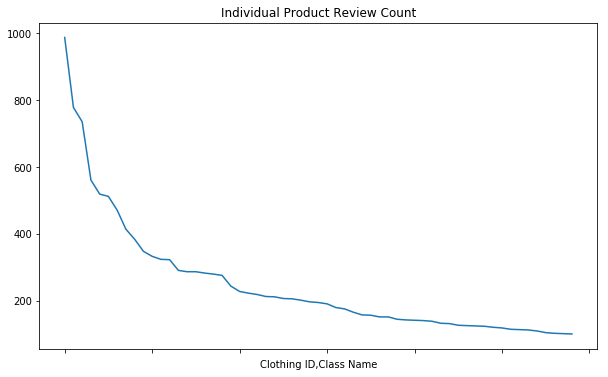

In [18]:
cloth_id[cloth_id['Clothing ID']['count'] > 100].plot(title='Individual Product Review Count', legend=False, figsize=(10,6), rot=90)

In [19]:
cloth_id['Clothing ID'][cloth_id['Clothing ID']['count'] ==1].count()

count    471
dtype: int64

In [20]:
# See if the classes of the number of products with reviews > 100 reflects overall numbers
cloth_id[cloth_id['Clothing ID']['count'] >100].groupby('Class Name').agg({('Clothing ID', 'count'):['count', 'sum']})

Clothing ID      
                 count      
                 count   sum
Class Name                  
Blouses             11  2247
Dresses             15  5156
Fine gauge           3   630
Jackets              2   279
Jeans                5   761
Knits               14  3856
Pants                4   704
Skirts               2   337
Sweaters             3   681

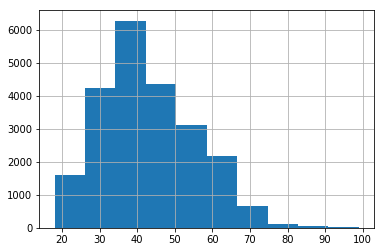

In [21]:
rev_data[('Age')].hist()

In [22]:
print ('Number below average of 43', rev_data.Age[rev_data['Age'] < 43].count())
print ('Number 43 & above', rev_data.Age[rev_data['Age'] >= 43].count())

Number below average of 43 12111
Number 43 & above 10530


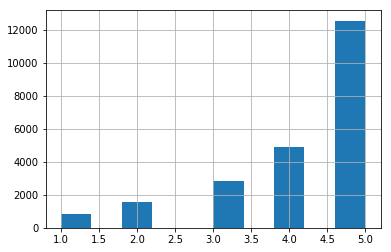

In [23]:
rev_data[('Rating')].hist()

**Observations**
The 3 category names, Division, Department and Class, seem similar but Class seems the most extensive in terms of range of values and may help to provide analysis once clusters have been formed.

Within Class, over a quarter of reviews are for dresses, with the other large groups being knits and blouses. These 3 classes make up over half of the reviews.

Average ratings for classs are just over 4 for nearly all categories except Trend which is 3.8. Perhaps the clothes are seen as not trendy? Something to look out for.

The recommended indicator merely follows the ratings so doesn't offer much new information.

Feedback count of other customers finding reviews positive, is higher per review for the higher categories, with 

Dresses with the largest ratio of over 3. The ratio drops slightly as the number of reviews drops, again until Trend where the ratio is also high. Interesting, but probably not much use at this stage (though might help to understand what makes a positive review if that was required?).

Age range is from 18 to 99, with the average being 43 and median 41. This might tell us something about the sorts of things that this age group are concerned about. There is a slight skew towards being younger than the average - 12.5k against around 11k above.

Ratings and recommendation indicator give us an idea of sentiment, and may help with analysis post clustering, although I am looking for insights outside of just sentiment.

Clothing ID shows the unique products. In total there are ~1200 products being reviewed, but nearly 500 of these have just a single review. 162 products have a review count greater than 20, with ~60 prods > 100 reviews. If the actual product were known, the resulting clusters could be grouped by product for feedback.

Of the top reviewed products by volume, the top 3 are in the Classes expected - dresses, knits and blouses.

A low number of products are responsible for most of the reviews:

Dresses: 5156 of 6145 revs from 15 prods - 84%

Knits: 3856 of 4626 revs from 14 prods - 83%

Blouses 2247 of 2983 revs from 11 prods - 75%

So nearly 50% of all reviews is from just 40 products

Assuming that this data represents reviews for all products, the above implies to me that these are the top sellers and get more reviews as more people have bought them. But it could imply that these are the most popular, despite sales. Either way, this retailer has 0.03% of its products making all the buzz. Some initial feedback could be to reduce the product line!

For my purposes here, this again might mean that the breadth of language and what is being talked about is limited. This might be useful giving distinct clusters, or it might mean that clusters are hard to define as language is "homogonous" and we can't distinguish one thing from another.

So let's get to the text!

In [24]:
rev_data['Title Word Count'] = rev_data['Title'].map(lambda x: len(x.split()))
rev_data['Review Word Count'] = rev_data['Review Text'].map(lambda x: len(x.split()))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [25]:
len(rev_data)

22641

Text(0, 0.5, 'Number of Reviews')

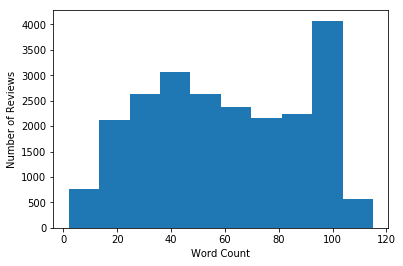

In [26]:
# rev_data[('Review Word Count')].hist()
plot = rev_data[('Review Word Count')].plot(kind="hist")
plot.set_xlabel("Word Count")
plot.set_ylabel("Number of Reviews")

In [27]:
rev_data['Review Word Count'].describe()

count    22641.000000
mean        60.196679
std         28.534612
min          2.000000
25%         36.000000
50%         59.000000
75%         88.000000
max        115.000000
Name: Review Word Count, dtype: float64

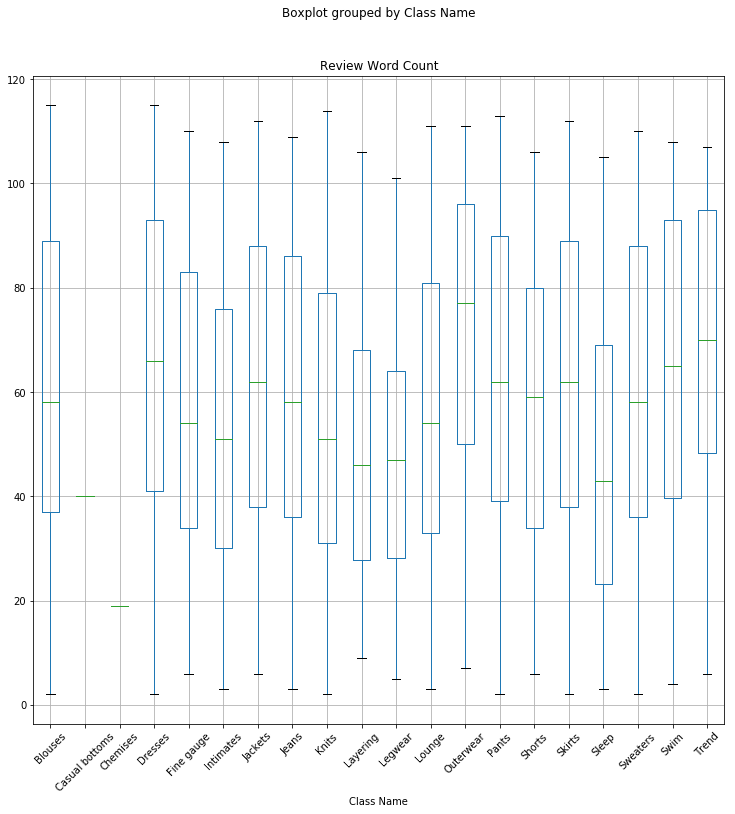

In [28]:
rev_data.boxplot(column='Review Word Count', by='Class Name', figsize=(12,12), rot=45)

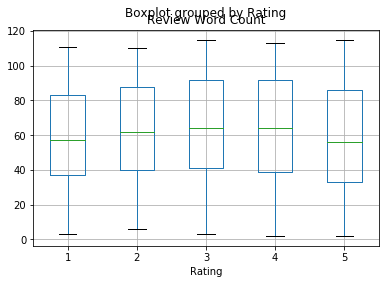

In [29]:
rev_data.boxplot(column='Review Word Count', by='Rating')

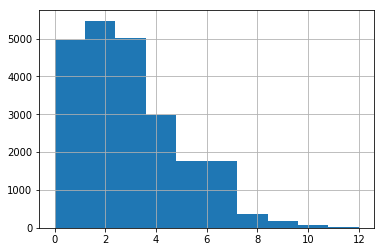

In [30]:
rev_data['Title Word Count'].hist()

**Text Observations**

Removing reviews with no text has reduced numbers by just over 800 and seems fairly random across age.

Word counts for the reviews are mainly 30-100 words, which is about 4 - 12 lines. Enough for a few sentences in each. There are around 700 short reviews, < 30 words, and around 500 long reviews, > 100. I don't forsee this as a problem but worth bearing in mind after clustering in case there is an impact.

These might be outliers, but I need to keep them in at this stage.

Distribution of word count seems fairly normal with a spike for reviews of around 100 words and mean of 60.

Titles are much shorter. I thought I'd check to see if there might be some meaning to glean here but I think the text is too short, so will ignore for now.

Let's take a look at some of the reviews to get a feel.

In [31]:
pd.set_option('display.max_colwidth', -1)
rev_data['Review Text'].sample(n=100)

22691    After readying the reviews of this dress, i thought for sure i was purchasing a winner. boy, was i wrong! first, this dress feels like a potato sack and looked like one on. i felt that it was very boxy and more of a o' one size fits all' sizing. it did not embrace my curves at all. the material was not as chic as i would have thought. overall, the entire dress was not flattering. honestly, i do not understand what the rave reviews were talking about it.                                               
7565     This is my new favorite sweater. soft and comfortable and easy to wear to both work and play. being able to wear different things under this makes it very versatile and easy to change looks.                                                                                                                                                                                                                                                                                               

**Initial Thoughts on Text**

There is a lot of positive text and this is borne out by the number of positive ratings. I'll look further into the breakdown. My worry is that this will give the language all of the same feel, so clusters might be large and indistinct.

The fact that the ratings are mainly about dresses, knitwear and blouses might also restrict the breadth of expression. But we will see.

I can also observe reviews contain multiple sentences, and these sentences themselves often contain more than one area of attention. 

For example, in this review extract: 

>  it was soft and cuddly, but a little baggy under the arms, and it shed everywhere.

This can be broken down into:

it was soft and cuddly

a little baggy under the arms

it shed everywhere

These make for nice discreet categories, so if the clustering algorithm can identify these and I allow a review to be in more than one cluster, then hopefully I'll see something like these. Splitting at sentence level might make sense in terms of reading clusters (rather than at review level) but splitting a sentence out might be harder as it isn't always obvious where the split of a sentence's meaning lies.

In [32]:
def percentage(part, whole):
  return 100 * float(part)/float(whole)

In [33]:
total_rec_cnt = rev_data.Rating.count()
rate_4_above = rev_data.Rating[rev_data['Rating'] > 3].count()
rate_3_below = rev_data.Rating[rev_data['Rating'] < 4].count()
rate_2_below = rev_data.Rating[rev_data['Rating'] < 3].count()
rate_4_above_perc = percentage(rate_4_above, total_rec_cnt)
rate_3_below_perc = percentage(rate_3_below, total_rec_cnt)
rate_2_below_perc = percentage(rate_2_below, total_rec_cnt)

print ('Total number of ratings {}. '.format(total_rec_cnt))

print ('Number of ratings 4 and above {}. Percentage of Total: {:.2f}'.format(rate_4_above,
                                                                           rate_4_above_perc))
print ('Number of ratings 3 and below {}. Percentage of Total: {:.2f}'.format(rate_3_below,
                                                                           rate_3_below_perc))
print ('Number of ratings 2 and below {}. Percentage of Total: {:.2f}'.format(rate_2_below,
                                                                       rate_2_below_perc))

Total number of ratings 22641. 
Number of ratings 4 and above 17448. Percentage of Total: 77.06
Number of ratings 3 and below 5193. Percentage of Total: 22.94
Number of ratings 2 and below 2370. Percentage of Total: 10.47


In [34]:
# Pull out individual products that are low rated and the class they are in
cloth_id_low_rate = pd.DataFrame(rev_data[rev_data['Rating'] < 3].groupby(['Clothing ID', 'Class Name']).agg({'Clothing ID':['count']}).sort_values(by=[('Clothing ID', 'count')], ascending=False))

cloth_id_low_rate

,,Clothing ID
,,count
Clothing ID,Class Name,
1078,Dresses,91
862,Knits,83
1094,Dresses,70
868,Knits,62
829,Blouses,51
867,Knits,48
1081,Dresses,46
1095,Dresses,43


In [35]:
# See if the classes of products rated 1 have just 1 review as well
# To see if negative reviews are on their own with no positives to balance them
cloth_id_low_rate[cloth_id_low_rate['Clothing ID']['count'] == 1].groupby('Class Name').agg({('Clothing ID', 'count'):['count', 'sum']})

Clothing ID    
                 count    
                 count sum
Class Name                
Blouses     4           4 
Dresses     9           9 
Fine gauge  11          11
Intimates   10          10
Jackets     13          13
Jeans       6           6 
Knits       3           3 
Layering    8           8 
Legwear     4           4 
Lounge      30          30
Outerwear   4           4 
Pants       9           9 
Shorts      8           8 
Skirts      3           3 
Sleep       19          19
Sweaters    7           7 
Swim        20          20
Trend       6           6

I checked to see if the low ratings (1 or 2) were the only review for a product, in case this might make the text "outliers" in the sense that they are a standalone criticism with no balance of a positive review. 172 products with a single review have a low rating, around a third of the products with a single rating. This is 3 times higher than the low rating across all products of 10%. 

But it's less than 10% of all low rated reviews. So whilst a lot of single review products have a higher chance of having a low rating (and more negative language) this doesn't represent a significant portion of the low rating text.

The losers with single ratings which are low are Loungewear, Swimwear and Sleepwear.

**Clean Up**

First check for special characters like:
* html - various tags
* editor instructions like \n \r

Item Count

\n - 2024

\r - 1398

"<" - 8

">" - 6

html head - 0

In [36]:
import re
def re_check_slash(text):
    return re.findall(r'(\n|\r|\t|\f)', text)

In [37]:
# Check for control characters
all_checks = []
for rev in rev_data['Review Text']:
    all_checks += re_check_slash(rev)

# Convert list to set of unique values
set(all_checks)

{'\n', '\r'}

So the text looks pretty clean, and these characters should get removed in text pre-processing.

**Text Analysis**

Here I will explore the text in more detail looking for patterns and any common words and expressions.

In [38]:
rev_data[rev_data.duplicated(subset='Review Text')]

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Title Word Count,Review Word Count
10067,10067,1171,26,Love retailer bathing suits!,Perfect fit and i've gotten so many compliments. i buy all my suits from here now!,5,1,0,Initmates,Intimate,Swim,4,16
11074,11074,628,60,Cute cover-up or summer top & shorts!,"Lightweight, soft cotton top and shorts. i think it's meant to be a beach cover-up but i'm wearing it as a thin, light-weight summer outfit on these hot hot days. the top has a loose elastic around the bottom which i didn't realize when i ordered it, but i like it and it matches the look in the photos. and the shorts are very low-cut - don't expect them up around your waist. again, i like that. some might want to wear a cami underneath because it's a thin cotton but i'm fine as-is. i bought it i",5,1,2,Initmates,Intimate,Lounge,7,98
12526,12526,1081,42,"Beautiful dress, fits horribly","I purchased this and another eva franco dress during retailer's recent 20% off sale. i was looking for dresses that were work appropriate, but that would also transition well to happy hour or date night. they both seemed to be just what i was looking for. i ordered a 4 regular and a 6 regular, as i am usually in between sizes. the 4 was definitely too small. the 6 fit, technically, but was very ill fitting. not only is the dress itself short, but it is very short-waisted. i am only 5'3"", but it fe",2,0,3,General,Dresses,Dresses,4,96
13354,13354,393,26,Love retailer bathing suits!,Perfect fit and i've gotten so many compliments. i buy all my suits from here now!,5,1,0,Initmates,Intimate,Swim,4,16
14275,14275,879,43,Love this shirt,"I bought this shirt at the store and after going home and trying it on, i promptly went online and ordered two more! i've gotten multiple compliments anytime i wear any of them. great for looking put together with no fuss. \r\npeople that have commented there's were destroyed in the wash didn't read the care label which says dry clean.",5,1,0,General Petite,Tops,Knits,3,60
21470,21470,895,60,Soft & beautiful!,"The sweater and skirt are so pretty! they're really soft and have such an easy, comfortable look together. really love this gorgeous outfit.\n\ni am borderline small/medium and kept the size small after trying both on.",5,1,5,General Petite,Tops,Fine gauge,3,36
21888,21888,1022,37,,"Love, love these jeans. being short they come right to my ankle. super soft and don?t require any hemming. i ordered my typical jean size of 26 and they fit like a glove. would love to have these in black and grey.",5,1,0,General,Bottoms,Jeans,0,42


In [39]:
undata = rev_data.drop_duplicates(subset='Review Text')

In [40]:
import string
import nltk
import nltk.data
nltk.download()   

from nltk import data, bigrams
# from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


In [41]:
# A few standard operations on the text to get to words that add value

def scrub_text(text,
               html=False,
               hyphen=False,
               stemmer=False,
               stopwords=False,
               punctuation=False,
               lem=False,
               w2v=False):
    """Return cleaned up text."""
    if html:
        text = BeautifulSoup(text).get_text()  # Deal with HTML

    if hyphen:
        text = ' '.join(re.split('[-]+', text)) # Split out hyphenated words 
    
    text = re.sub('\.(?!\s)(?!$)', '. ', text) # Add space after "."
    
    word_tokens = word_tokenize(text.lower())
    if punctuation:
        word_tokens = [word for word in word_tokens if word not in punctuation]
    word_tokens = [word for word in word_tokens if word.isalnum()]
    word_tokens = [word for word in word_tokens if not word.isdigit()]
    
    if stopwords:
        word_tokens = [word for word in word_tokens if word not in stopwords]
    
    if lem:
        word_tokens = [lem.lemmatize(word) for word in word_tokens]
    
    if stemmer:
        word_tokens=[stemmer.stem(word) for word in word_tokens]
    
    if w2v:
        return word_tokens
    else:
        return ' '.join(word_tokens)

In [42]:
# clean text - tokenize, remove stopwords & punctuation but don't stem or lem

#lem = nltk.WordNetLemmatizer()
#stemmer = SnowballStemmer("english")
sw = stopwords.words('english')
punctuation=set(list(string.punctuation))

undata['cleantxt'] = undata['Review Text'].map(lambda x: scrub_text(x,
                                                                    hyphen=True,
                                                                    stopwords=sw,
                                                                    punctuation=punctuation))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [43]:
undata.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Title Word Count,Review Word Count,cleantxt
0,0,767,33,,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Initmates,Intimate,Intimates,0,8,absolutely wonderful silky sexy comfortable
1,1,1080,34,,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5,1,4,General,Dresses,Dresses,0,62,love dress sooo pretty happened find store glad bc never would ordered online bc petite bought petite love length hits little knee would definitely true midi someone truly petite
2,2,1077,60,Some major design flaws,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",3,0,0,General,Dresses,Dresses,4,98,high hopes dress really wanted work initially ordered petite small usual size found outrageously small small fact could zip reordered petite medium overall top half comfortable fit nicely bottom half tight layer several somewhat cheap net layers imo major design flaw net layer sewn directly zipper c
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5,1,0,General Petite,Bottoms,Pants,3,22,love love love jumpsuit fun flirty fabulous every time wear get nothing great compliments
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5,1,6,General,Tops,Blouses,2,36,shirt flattering due adjustable front tie perfect length wear leggings sleeveless pairs well cardigan love shirt


In [44]:
# Build a list of all words from reviews in order to create a corpus

def create_corpus(data, text_field):
    """Return NLTK text corpus."""
    cnt = 0 
    build_text = []
    for row in data[text_field]:
        token = word_tokenize(row)
        build_text.extend(token)
        cnt += 1
        if cnt % 5000 == 0:
            print("Docs processed:", cnt)

    corp = nltk.Text(build_text)
    return corp, build_text

In [45]:
corp_data, tokens = create_corpus(undata, 'cleantxt')

Docs processed: 5000
Docs processed: 10000
Docs processed: 15000
Docs processed: 20000


In [46]:
len(tokens)

635768

In [47]:
freq_dist = nltk.FreqDist(corp_data)
freq_dist.most_common(50)

[('dress', 10539),
 ('love', 8942),
 ('size', 8751),
 ('top', 7393),
 ('fit', 7300),
 ('like', 7143),
 ('wear', 6433),
 ('great', 6114),
 ('would', 5429),
 ('fabric', 4787),
 ('small', 4673),
 ('color', 4582),
 ('look', 4028),
 ('really', 3922),
 ('ordered', 3846),
 ('little', 3775),
 ('perfect', 3769),
 ('one', 3635),
 ('flattering', 3515),
 ('well', 3390),
 ('soft', 3332),
 ('back', 3213),
 ('comfortable', 3055),
 ('cute', 3041),
 ('nice', 3020),
 ('bought', 2983),
 ('beautiful', 2964),
 ('looks', 2873),
 ('bit', 2866),
 ('fits', 2853),
 ('large', 2815),
 ('shirt', 2808),
 ('material', 2760),
 ('much', 2709),
 ('length', 2672),
 ('also', 2587),
 ('sweater', 2512),
 ('long', 2460),
 ('got', 2426),
 ('could', 2384),
 ('jeans', 2372),
 ('colors', 2360),
 ('petite', 2339),
 ('waist', 2326),
 ('quality', 2290),
 ('medium', 2231),
 ('pretty', 2192),
 ('think', 2185),
 ('even', 2172),
 ('retailer', 2156)]

In [48]:
top_words = pd.DataFrame(freq_dist.most_common(10), columns=('Word', 'Count'))
top_words

,Word,Count
0,dress,10539
1,love,8942
2,size,8751
3,top,7393
4,fit,7300
5,like,7143
6,wear,6433
7,great,6114
8,would,5429
9,fabric,4787


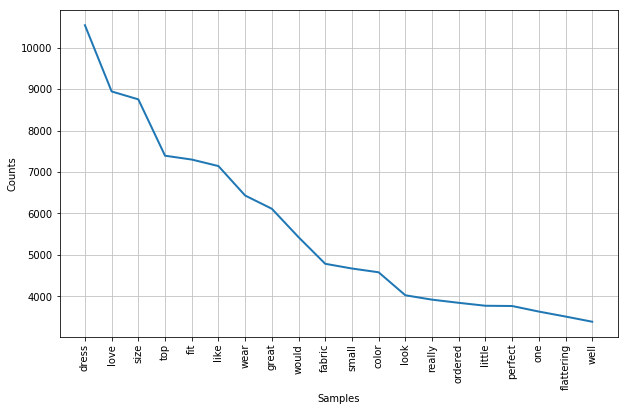

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

freq_dist.plot(20,cumulative=False)

In [50]:
corp_data.collocations()

true size; highly recommend; well made; usually wear; fits perfectly;
fit perfectly; many compliments; usual size; skinny jeans; looks
great; arm holes; form fitting; runs large; full price; even though;
super cute; normally wear; super soft; going back; high quality


In [51]:
# calculate bigrams
terms_bigram = bigrams(tokens)
bi_fdist = nltk.FreqDist(terms_bigram)
top_bigrams = pd.DataFrame(bi_fdist.most_common(50), columns=('Word Pair', 'Count'))
top_bigrams

,Word Pair,Count
0,"(true, size)",1343
1,"(love, dress)",747
2,"(usually, wear)",690
3,"(looks, great)",622
4,"(well, made)",606
5,"(fit, perfectly)",604
6,"(love, top)",571
7,"(size, small)",524
8,"(fits, perfectly)",486
9,"(usual, size)",479


In [52]:
corp_data.similar('dress')

top fit shirt love color sweater fabric size skirt really colors great
flattering one would comfortable look perfect small pants


In [53]:
corp_data.concordance('back')

Displaying 25 of 3213 matches:
istmas dress year needless say going back dress perfection pretty flattering f
pregnant bough medium grow tie front back provides nice flexibility form fitti
kirt portion pretty poofy keep going back forth mainly price although quality 
p wear leggings bought slip wore tie back rocked white wedges could also wear 
aned ordered months ago finally came back order huge disappointment fit much i
le still worth paid definitely going back neat dress color great fabric super 
 pilcro stet jeans flattering peplum back nice cut shoulders neckline pretty u
nerally wear small fit well probably back black bought item online fit model l
loose got mine seemed bit tight took back store ordered larger size sale price
tty unusual look great slight peplum back hangs nicely lightweight tee fabric 
es though tank fit well loved ruffle back layed front good look retuning got p
lor nice lines downside retailer tag back itchy need remove dress simply beaut
rfect could happier p

**More thoughts on text**

As expected, the top words appearing are for dress and love - very positive! Followed by size, top, fit and like.
This isn't revealing much beyond what I'd expect with reviews on womens clothes. Fabric and color are around the 10th position and probably the first words I'd rate as carrying some meaning that might useful feedback.

Ordered appears around 15th which might indicate some feedback on the ordering process.

Lots of words about attributes of clothes and sizes.

****Again, collocations reveal some positive pairings if words like fits perfectly and highly recommended! "Going back" and "full price" stand out as possible negatives that occur though price isn't mentioned in the top 50 pairings but going back does have nearly 300 mentions.


In [54]:
corp_data.common_contexts(['going', 'back'])

small_order one_get detail_front could_back one_home detail_fabric
back_back longer_wearing way_keep


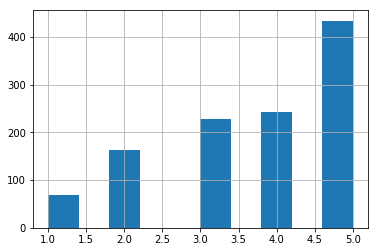

In [55]:
undata['Rating'][undata['Review Text'].str.contains('going', 'back')].hist()

In [56]:
print(undata['Rating'][undata['Review Text'].str.contains('going', 'back')].count())
print(undata['Rating'][undata['Review Text'].str.contains('going', 'back')].value_counts())

1138
5    434
4    242
3    229
2    164
1    69 
Name: Rating, dtype: int64


In [57]:
print(undata['Rating'][undata['Review Text'].str.contains('ordered')].count())
print(undata['Rating'][undata['Review Text'].str.contains('ordered')].value_counts())

3405
5    1598
4    827 
3    513 
2    318 
1    149 
Name: Rating, dtype: int64


As I suspected, text containing 'going' and 'back' has much lower ratings - about 20% 1 or 2, compared with overall of 10%.

Ordered is less higher than overall at just under 14% low ratings.

In [58]:
corp_data.similar('ordered')

bought got size tried purchased love small dress usually petite went
wear medium top true perfect fit order regular xs


## Clustering - Benchmark
First use a KMeans model for a benchmark.

Break out reviews to sentences.

Need to do some pre-processing which can be used for the main model too.

In [59]:
# Can use the Unnamed column as a unique review ID
undata.rename(columns={'Unnamed: 0': 'Review ID'}, inplace=True)
undata.head(2)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Title Word Count,Review Word Count,cleantxt
0,0,767,33,,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Initmates,Intimate,Intimates,0,8,absolutely wonderful silky sexy comfortable
1,1,1080,34,,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5,1,4,General,Dresses,Dresses,0,62,love dress sooo pretty happened find store glad bc never would ordered online bc petite bought petite love length hits little knee would definitely true midi someone truly petite


In [60]:
# Download the punkt tokenizer for sentence splitting
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [61]:
def review_to_sentences(review, tokenizer, sw, punctuation):
    """Split a review into parsed sentences.
    
    Returns 2 lists of sentences:
    1. Raw sentences - just the review split by sentence
    2. Scrubbed sentences.
    
    Each sentence is a list of words."""
    
    raw_sentences = tokenizer.tokenize(review.strip())
    
    scrub_sentences = [scrub_text(raw_sentence, stopwords=sw, punctuation=punctuation)
                       for raw_sentence in raw_sentences if len(raw_sentence) > 0]

    return raw_sentences, scrub_sentences

In [62]:
# Build a review only list
review_text = undata[['Review ID', 'Review Text']].values.tolist()
review_text[0:3]

[[0, 'Absolutely wonderful - silky and sexy and comfortable'],
 [1,
  'Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.'],
 [2,
  'I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c']]

In [63]:
# Create a list of sentences with both raw and scrubbed sentences
# Scrubbed to be used in models, raw to refer back to for human undertanding and display
# [[review id <1203>, raw_sent, scrbd_sent], [...]]
# Review id is not unique. May need to add unique sentence ID at some point

review_sentences = []
for rev in review_text:
    sent, scrbd_sent = review_to_sentences(rev[1], tokenizer, sw, punctuation)
    for item in zip(sent, scrbd_sent):
        review_sentences.append([rev[0], item[0], item[1]])
review_sentences[0:10]

[[0,
  'Absolutely wonderful - silky and sexy and comfortable',
  'absolutely wonderful silky sexy comfortable'],
 [1, 'Love this dress!', 'love dress'],
 [1, "it's sooo pretty.", 'sooo pretty'],
 [1,
  "i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite.",
  'happened find store glad bc never would ordered online bc petite'],
 [1, 'i bought a petite and am 5\'8".', 'bought petite'],
 [1,
  'i love the length on me- hits just a little below the knee.',
  'love length hits little knee'],
 [1,
  'would definitely be a true midi on someone who is truly petite.',
  'would definitely true midi someone truly petite'],
 [2,
  'I had such high hopes for this dress and really wanted it to work for me.',
  'high hopes dress really wanted work'],
 [2,
  'i initially ordered the petite small (my usual size) but i found this to be outrageously small.',
  'initially ordered petite small usual size found outrageously small'],
 [2, 'so small in 

In [64]:
# Convert to a dataframe for convenience
rev_sent = pd.DataFrame(review_sentences,
                        columns=('Review ID', 'Review Sent', 'Review Scrub'))
rev_sent.head()

,Review ID,Review Sent,Review Scrub
0,0,Absolutely wonderful - silky and sexy and comfortable,absolutely wonderful silky sexy comfortable
1,1,Love this dress!,love dress
2,1,it's sooo pretty.,sooo pretty
3,1,"i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite.",happened find store glad bc never would ordered online bc petite
4,1,"i bought a petite and am 5'8"".",bought petite


In [65]:
# Scrubbing may have removed all words - drop sentences that are blank after scrubbing
rev_sent = rev_sent[rev_sent['Review Scrub'] != '']
rev_sent_un = rev_sent.drop_duplicates(subset='Review Scrub')
rev_sent_un.reset_index(inplace=True)

This is WAY too big for running cosine similarity for the main model later. I need to reduce the number of sentences, probably to 10k or less.
Let's try removing small sentences.

In [66]:
rev_sent_un['Word Count'] = rev_sent_un['Review Scrub'].map(lambda x: len(x.split()))
rev_sent_large = rev_sent_un[rev_sent_un['Word Count'] > 5]
rev_sent_large.reset_index(inplace=True)
rev_sent_large.count()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


level_0         49183
index           49183
Review ID       49183
Review Sent     49183
Review Scrub    49183
Word Count      49183
dtype: int64

This is still probably too large for a cosine sim so I will sample at 10% and see how much I can get.

If things work OK I will experiment with increasing sample size by returning here.

In [67]:
rev_sent_lrg_sample = rev_sent_large[['Review ID',
                                      'Review Sent',
                                      'Review Scrub',
                                      'Word Count']].sample(n=30000)
rev_sent_lrg_sample.reset_index(inplace=True)
rev_sent_lrg_sample.rename(columns={'index': 'Sentence ID'}, inplace=True)
rev_sent_lrg_sample.head()

,Sentence ID,Review ID,Review Sent,Review Scrub,Word Count
0,4030,1923,"the material is incredibly soft, but i haven't laundered it yet, so i am not sure how it will holdup.",material incredibly soft laundered yet sure holdup,7
1,33523,16116,i bought the 6p and 4p and the 4p fit best.,bought 6p 4p 4p fit best,6
2,18307,8772,I purchased these pants on 12/2/15 as a more fashionable alternative to yoga pants while traveling southeast asia starting february.,purchased pants fashionable alternative yoga pants traveling southeast asia starting february,11
3,20062,9633,too tight around arms and way big and boxy around the mid-section.,tight around arms way big boxy around,7
4,5503,2595,the back is longer than the front and it's almost a pregnancy top in how much it flairs.,back longer front almost pregnancy top much flairs,8


Now vectorize for KMeans using TFIDF.

Run KMeans.

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans

In [69]:
# Calculate TF and tfidf scores
# Creates a bag of words with a sparse matrix for each sentence

vectorizer = TfidfVectorizer(min_df=2)
vz = vectorizer.fit_transform([rev for rev in rev_sent_lrg_sample['Review Scrub']])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
checkword = 'dress'
print("{}: {}".format(checkword, str(tfidf[checkword])))

dress: 3.1404995762954004


In [70]:
vz.shape

(30000, 5522)

In [71]:
num_clusters = 50
kmeans_model = KMeans(init='k-means++', n_clusters=num_clusters, n_init=10,verbose=False)

kmeans = kmeans_model.fit(vz)
kmeans_clusters = kmeans.predict(vz)
kmeans_distances = kmeans.transform(vz)

In [72]:
# print the cluster center
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(num_clusters):
    print('Cluster {}:'.format(i))
    for j in sorted_centroids[i, :20]:
        print(' {}'.format(terms[j]))
    print()

Cluster 0:
 true
 size
 fits
 fit
 runs
 small
 great
 dress
 found
 pretty
 run
 say
 top
 like
 usually
 little
 comfortable
 ordered
 wear
 would

Cluster 1:
 jeans
 skinny
 great
 pair
 leggings
 looks
 wear
 pants
 black
 worn
 look
 shorts
 white
 boots
 skirt
 casual
 well
 pilcro
 perfect
 top

Cluster 2:
 figure
 flattering
 hourglass
 dress
 curvy
 fit
 would
 waist
 straight
 well
 look
 like
 made
 skirt
 top
 without
 someone
 great
 little
 curves

Cluster 3:
 back
 love
 went
 like
 going
 dress
 detail
 send
 fabric
 tie
 little
 shirt
 buttons
 one
 bra
 design
 top
 also
 go
 get

Cluster 4:
 soft
 material
 fabric
 comfortable
 super
 great
 like
 color
 love
 really
 sweater
 flattering
 warm
 top
 comfy
 cozy
 colors
 pretty
 lovely
 beautiful

Cluster 5:
 long
 sleeves
 length
 short
 torso
 enough
 sleeve
 bit
 wear
 arms
 little
 time
 like
 perfect
 fit
 petite
 also
 shirt
 great
 still

Cluster 6:
 think
 would
 look
 dress
 like
 wear
 flattering
 fit
 great

In [73]:
# Add cluster number to the sentences and create df

rev_sent_lrg_sample['K Cluster'] = kmeans_clusters
rev_sent_lrg_sample.head()

,Sentence ID,Review ID,Review Sent,Review Scrub,Word Count,K Cluster
0,4030,1923,"the material is incredibly soft, but i haven't laundered it yet, so i am not sure how it will holdup.",material incredibly soft laundered yet sure holdup,7,4
1,33523,16116,i bought the 6p and 4p and the 4p fit best.,bought 6p 4p 4p fit best,6,37
2,18307,8772,I purchased these pants on 12/2/15 as a more fashionable alternative to yoga pants while traveling southeast asia starting february.,purchased pants fashionable alternative yoga pants traveling southeast asia starting february,11,37
3,20062,9633,too tight around arms and way big and boxy around the mid-section.,tight around arms way big boxy around,7,20
4,5503,2595,the back is longer than the front and it's almost a pregnancy top in how much it flairs.,back longer front almost pregnancy top much flairs,8,19


### Examine Benchmark Results
Some functions to help present clusters visually - Clusters list, word clouds and word counts.

In [74]:
def create_stats(clusters):
    """Return stats in a dataframe."""

    unique, counts = np.unique(clusters, return_counts=True)
    stats = pd.DataFrame(list(zip(unique, counts)), columns=['cluster','count'])

    stats.sort_values('count', ascending=False, inplace=True)
    return stats

In [75]:
def cluster_wordrank(docs, min_df=1):
    """Returns a dataframe of word and count."""
    cvec = CountVectorizer(min_df=min_df)
    cts = cvec.fit_transform(docs)
    vocab = list(cvec.get_feature_names())
    counts = cts.sum(axis=0).A1

    d = pd.DataFrame(list(zip(vocab, counts)))
    d.columns = ['word', 'raw count']
    d.sort_values('raw count', inplace=True, ascending=False)
    # d.reset_index('word',inplace=True)
    return d

In [76]:
from wordcloud import WordCloud

def make_wordcloud(word_list, top_n):
    """Returns a wordcloud of the top words provided."""
    counts = {}
    for r in cluster_wordrank(word_list)[['word','raw count']].head(top_n).iterrows():
        counts[r[1]['word']] = int(r[1]['raw count'])

    wordcloud = WordCloud(scale=10)
    wordcloud.fit_words(counts)

    # Display the generated image the matplotlib way
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

In [77]:
create_stats(kmeans_clusters)

,cluster,count
37,37,5161
16,16,1063
30,30,1056
12,12,828
17,17,780
39,39,771
36,36,769
34,34,728
48,48,704
7,7,699


In [78]:
inquiry_cluster = 1
rev_sent_lrg_sample['Review Sent'][rev_sent_lrg_sample['K Cluster'] == inquiry_cluster].head(10)

157    I've never spent this much on a pair of jeans, but per another customer review that they were "worth every penny" i took the plunge.        
191    looks amazing paired with booties, a statement necklace and jeans.                                                                          
297    i usually wear a 28 and sometimes even a 29 in most ag and mother jeans.                                                                    
394    heavier material of neutral tone ( with detailing of epaulets) pairs well with dresses, skirts, jeans, jeggings and whatever style of boots.
404    definitely pair it with bodycon pants/ leggings/ skinny jeans - and it looks unique and very professional.                                  
566    also, these jeans are really stretchy which makes them a dream to wear.                                                                     
632    i wear a 26, but it is often difficult to find a good fitting pair of jeans.                             

In [79]:
cluster_wordrank(rev_sent_lrg_sample['Review Scrub'][rev_sent_lrg_sample['K Cluster'] == inquiry_cluster])

,word,raw count
511,jeans,646
896,skinny,166
434,great,132
1119,wear,104
690,pair,93
571,looks,87
545,leggings,78
568,look,71
94,black,67
696,pants,66


In [80]:
def show_cloud_for_cluster(cluster_no):
    make_wordcloud(rev_sent_lrg_sample['Review Scrub'][rev_sent_lrg_sample['K Cluster'] == cluster_no], 20)

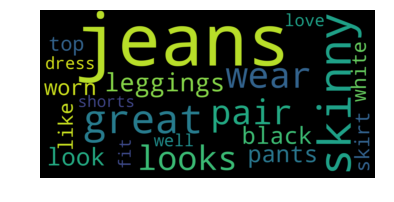

In [81]:
show_cloud_for_cluster(inquiry_cluster)

In [82]:
inquiry_cluster = 8
rev_sent_lrg_sample['Review Sent'][rev_sent_lrg_sample['K Cluster'] == inquiry_cluster].head(10)

138    the model has the waist band pulled lower than i think you'd most likely be wearing it making the outfit appear longer.
190    bought a small, length and fit similar to model                                                                        
263    The shirt looks a lot less fitted on the model in the picture than how it fit in "real" life.                          
377    colors are true to the pictures shown and length falls as shown on model.                                              
399    it fits just like the model but the back droops a bit and the neck is wider.                                           
407    also, the layering looks nothing like it does on the model, it looks sloppy, unkept and a general.                     
571    This is a beautiful top, however it looks better on the 80 pound model.                                                
679    material was thinner than i'd hoped, doesn't look as smooth as on the model.                            

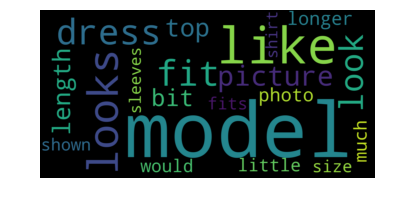

In [83]:
show_cloud_for_cluster(inquiry_cluster)

## Graph Clustering
Start with running Word2Vec and taking the vectors from this output.

In [84]:
# Convert string of words to a list
rev_sent_lrg_sample['sent w2v'] = rev_sent_lrg_sample['Review Scrub'].map(lambda x: word_tokenize(x))
rev_sent_lrg_sample.head()

,Sentence ID,Review ID,Review Sent,Review Scrub,Word Count,K Cluster,sent w2v
0,4030,1923,"the material is incredibly soft, but i haven't laundered it yet, so i am not sure how it will holdup.",material incredibly soft laundered yet sure holdup,7,4,"[material, incredibly, soft, laundered, yet, sure, holdup]"
1,33523,16116,i bought the 6p and 4p and the 4p fit best.,bought 6p 4p 4p fit best,6,37,"[bought, 6p, 4p, 4p, fit, best]"
2,18307,8772,I purchased these pants on 12/2/15 as a more fashionable alternative to yoga pants while traveling southeast asia starting february.,purchased pants fashionable alternative yoga pants traveling southeast asia starting february,11,37,"[purchased, pants, fashionable, alternative, yoga, pants, traveling, southeast, asia, starting, february]"
3,20062,9633,too tight around arms and way big and boxy around the mid-section.,tight around arms way big boxy around,7,20,"[tight, around, arms, way, big, boxy, around]"
4,5503,2595,the back is longer than the front and it's almost a pregnancy top in how much it flairs.,back longer front almost pregnancy top much flairs,8,19,"[back, longer, front, almost, pregnancy, top, much, flairs]"


In [85]:
# Run W2V on all text to create a larger vectorspace

import gensim
w2v_full = gensim.models.Word2Vec(rev_sent_lrg_sample['sent w2v'], workers=8, iter=10, size=100, min_count=2)

/opt/conda/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [86]:
w2v_full.most_similar('dress', topn=20)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('blouse', 0.6502242684364319),
 ('absolutley', 0.617827296257019),
 ('thoughtfully', 0.6040319800376892),
 ('shirtdresses', 0.6028386354446411),
 ('top', 0.5978412628173828),
 ('strictly', 0.5957072973251343),
 ('decision', 0.5899884700775146),
 ('heights', 0.5882196426391602),
 ('horrendous', 0.5855227708816528),
 ('patchwork', 0.5853925943374634),
 ('absolutely', 0.5844626426696777),
 ('impact', 0.577670693397522),
 ('swimsuit', 0.5765485167503357),
 ('jogger', 0.5759543180465698),
 ('idea', 0.5703038573265076),
 ('belted', 0.5677300691604614),
 ('conversation', 0.5672767758369446),
 ('darn', 0.5671079754829407),
 ('tapestry', 0.5663588047027588),
 ('cheaply', 0.5648292303085327)]

In [87]:
len(w2v_full.wv.vocab)

5557

In [88]:
len(w2v_full.wv.index2word)

5557

A couple of helper functions to create sentence level vectors, ie bag of words

In [89]:
def create_doc_vector (doc, model, vector_size):
    # Average all of the word vectors in a given text document
    
    doc_vector = np.zeros((vector_size,), dtype='float32')
    num_words = 0.    
    index2word_set = set(model.wv.index2word)
    
    for word in doc:
        if word in index2word_set:
            num_words += 1.
            doc_vector = np.add(doc_vector, model[word])
            
    # Divide result by number of words to get average
    doc_vector = np.divide(doc_vector, num_words)
    return doc_vector

In [90]:
def get_doc_vecs(docs, model, vector_size):
    # Calculate the average vector for each text document
    
    cnt = 0
    doc_vecs = np.zeros((len(docs), vector_size), dtype='float32')
    
    for doc in docs:
        if cnt % 100000 == 0:
            print('Doc {} of {}'.format(cnt, len(docs)))
            
        doc_vecs[cnt] = create_doc_vector(doc, model, vector_size)
        cnt += 1
    return doc_vecs

In [91]:
vector_size = 100

vector_space = get_doc_vecs(rev_sent_lrg_sample['sent w2v'], w2v_full, vector_size)
vector_space

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


Doc 0 of 30000


array([[ 0.629303  ,  0.30660033,  0.29077888, ...,  0.45293498,
        -0.07771183, -0.30034283],
       [ 0.22590823,  0.3492554 ,  0.03699163, ...,  0.09612415,
         0.21913882,  0.06017669],
       [ 0.09721733,  0.64525527, -0.06315297, ...,  0.19796196,
         0.01483454, -0.2010161 ],
       ...,
       [ 0.7083615 ,  0.64453465, -0.433125  , ...,  0.3656998 ,
        -0.33914   ,  0.0379788 ],
       [ 0.72481674,  0.15719382,  0.00259852, ...,  0.33247444,
        -0.0233143 , -0.15362145],
       [ 0.7259069 ,  0.6574549 , -0.17858344, ..., -0.12749751,
         0.01340503, -0.05315313]], dtype=float32)

In [92]:
vector_space.shape

(30000, 100)

In [93]:
# Checks if nulls found in vector space
chck = pd.DataFrame(vector_space)
chck[chck.isnull().T.any().T]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99


In [94]:
# Drop relevant nulls and re-run (save them first)
unused_sent = rev_sent_clusters[chck.isnull().T.any().T]
unused_sent

NameError: name 'rev_sent_clusters' is not defined

In [ ]:
rev_sent_clusters = rev_sent_clusters[chck.notnull().T.any().T]

Now go back and re-run creating vector space if there were nulls.

Continue on by normalizing the vectors to 0-1.

In [96]:
from sklearn.preprocessing import normalize

In [97]:
vector_space_norm = normalize(vector_space)
vector_space_norm

array([[ 0.1764499 ,  0.08596749,  0.08153132, ...,  0.12699817,
        -0.02178957, -0.08421295],
       [ 0.07939383,  0.12274332,  0.01300044, ...,  0.03378214,
         0.07701477,  0.02114867],
       [ 0.04400142,  0.29204825, -0.02858359, ...,  0.08959933,
         0.00671424, -0.09098166],
       ...,
       [ 0.18141405,  0.16506775, -0.11092494, ...,  0.09365709,
        -0.08685503,  0.00972651],
       [ 0.26023617,  0.05643843,  0.00093297, ...,  0.11937068,
        -0.0083707 , -0.05515581],
       [ 0.20794891,  0.18833962, -0.05115839, ..., -0.03652392,
         0.00384011, -0.01522666]], dtype=float32)

In [98]:
def get_sims(vecs, raw=False):
    """Calculate cosine similarity - matrix dot product."""
    # expects np.matrix
    if not raw:
        vecs_adj = (vecs > 0).astype(int)
    else:
        vecs_adj = vecs
    
    extras = [vecs_adj]
    sims = np.dot(vecs_adj, vecs_adj.T)
    
    np.fill_diagonal(sims,0)
    return sims, extras

In [99]:
sims, etc = get_sims(vector_space_norm, raw=True)
len(sims[0])

30000

In [100]:
sims

array([[0.        , 0.20098867, 0.24876314, ..., 0.34246945, 0.79939544,
        0.41143438],
       [0.20098867, 0.        , 0.7715019 , ..., 0.54465276, 0.4749766 ,
        0.44895282],
       [0.24876314, 0.7715019 , 0.        , ..., 0.52028936, 0.49049997,
        0.4556195 ],
       ...,
       [0.34246945, 0.54465276, 0.52028936, ..., 0.        , 0.44644699,
        0.32112497],
       [0.79939544, 0.4749766 , 0.49049997, ..., 0.44644699, 0.        ,
        0.6503088 ],
       [0.41143438, 0.44895282, 0.4556195 , ..., 0.32112497, 0.6503088 ,
        0.        ]], dtype=float32)

The main functions that implement the Chinese Whispers algorithm.

In [101]:
import networkx as nx
import random

def prune_graph(G, threshold):
    """Remove any nodes that have no edges."""
    for n in G.nodes(data=True):
        if G.degree(n[0]) <= threshold:
            G.remove_node(n[0])

In [102]:
def cw(G, iterations=3, class_label='class', weight_label='weight'):
    """Run the Chinese Whispers algorithm on the graph."""
    for c,n in enumerate(G.nodes()):
        G.node[n]['class'] = c

    for z in range(0, iterations):
        gn = G.nodes()
        # Randomize the nodes to give an arbitrary start point
        # random.shuffle(gn)
        random.sample(gn, k=len(gn))
        for node in gn:
            neighs = G[node]
            classes = {}
            # do an inventory of the given nodes neighbours and edge weights
            for ne in neighs:
                if G.node[ne][class_label] in classes:
                    classes[G.node[ne][class_label]] += G[node][ne][weight_label]
                else:
                    classes[G.node[ne][class_label]] = G[node][ne][weight_label]
            # find the class with the highest edge weight sum
            maxi = 0
            maxclass = 0
            for c in classes:
                if classes[c] > maxi:
                    maxi = classes[c]
                    maxclass = c
            # set the class of target node to the winning local class
            G.node[node][class_label] = maxclass
    return G

In [103]:
def cw_all(sims, lookup=False, lookup_id=False, threshold=0.5, iterations=3, 
           write_df=False, write_df_col='cluster', write_df_key=False,
           class_label='class', weight_label='weight'
          ):
    
    if type(sims) is not np.matrix:
        raise Exception('Requires matrix of type np.matrix')
        
    if type(lookup) == pd.core.frame.DataFrame or type(lookup) == dict:
        print("creating graph from dataframe")
        G = nx.Graph()
        edges = []
        edge_cnt = 0.
        for n, s in enumerate(sims):
            src = lookup.iloc[n].name
            for t in np.nonzero(s >= threshold)[1]:
                if t <= n:
                    continue
                if lookup_id:
                    if type(lookup_id) is int:
                        src = lookup.iat[n,lookup_id]
                        trg = lookup.iat[t,lookup_id]
                    else:
                        src = lookup.iloc[n][lookup_id]
                        trg = lookup.iloc[t][lookup_id]
                else:
                    trg = lookup.iloc[t].name
                edges.append((src,trg,s.A[0][t]))
                if edge_cnt % 50000 == 0.:
                    print('Edge count {}'.format(edge_cnt))
                edge_cnt += 1

        #return edges
        G.add_weighted_edges_from(edges)
        #print(nx.info(G))
    else:
        print("creating graph from matrix")
        G = nx.from_numpy_matrix(sims)
    
    prune_graph(G, 0)
    print('running CW')

    G = cw(G, iterations=iterations)
    
    if type(write_df) == pd.core.frame.DataFrame:
        print("writing to DF")
        if not write_df_key:
            if lookup_id:
                write_df_key = lookup_id
            else:
                return G
            return G
            
        write_df[write_df_col] = write_df[write_df_key].apply(lambda x: G.node[x][class_label] if x in G.node.keys() else -1)

    print("creating stats")
    cw_cls = np.array([G.node[n][class_label] for n in G.node])
    unique, counts = np.unique(cw_cls, return_counts=True)

    stats = pd.DataFrame(list(zip(unique, counts )))
    stats.sort_values(1, ascending=False)
    stats.columns = ['cluster','count']
    
    return G, stats

In [104]:
# Create a df with Sentence ID as index
df_main = pd.DataFrame(rev_sent_lrg_sample['Sentence ID'])
#df_main.set_index(0, inplace=True)

df_main.reset_index(drop=True, inplace=True)
df_v = pd.DataFrame(vector_space_norm)
df_main = pd.concat([df_main, df_v], axis=1)
df_master = df_main.copy()
df_main.set_index('Sentence ID', inplace=True)
df_main

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
Sentence ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4030,0.176450,0.085967,0.081531,-0.171979,0.111526,0.125782,0.040321,0.095206,0.075005,-0.001705,-0.019261,0.067307,-0.044381,-0.057020,0.074357,0.055559,-0.167363,0.041025,-0.103120,0.125993,-0.231664,0.088995,-0.062168,0.117241,0.029882,-0.020307,0.042758,-0.131493,-0.036420,-0.105135,-0.109072,0.148083,-0.038819,0.102634,0.041533,-0.070475,0.088004,-0.088072,0.198288,0.143844,...,-0.080906,-0.064369,0.038106,0.012003,-0.172616,0.079522,0.088158,0.097308,-0.241577,-0.049599,-0.054955,0.198685,0.074376,-0.197155,0.097999,-0.011113,-0.072548,-0.082096,-0.070885,-0.071633,-0.017462,-0.031765,0.091632,-0.015209,0.092888,-0.176123,-0.087331,-0.102348,0.014853,-0.117047,0.082209,-0.050817,-0.081193,-0.030553,0.094932,0.084831,0.033991,0.126998,-0.021790,-0.084213
33523,0.079394,0.122743,0.013000,0.129442,0.064476,0.161280,0.116733,0.034547,-0.112420,-0.037494,-0.032749,0.173637,-0.233843,-0.007482,-0.008840,-0.060348,-0.028018,0.017973,0.056999,0.014903,-0.041078,0.125594,-0.082037,0.027188,0.112320,0.007669,0.016440,-0.001663,0.103375,-0.002979,-0.026780,0.035493,-0.064321,0.099008,0.020014,-0.141029,-0.109784,-0.198026,0.047692,0.170575,...,-0.006965,0.041856,-0.022438,-0.037595,-0.118498,0.064107,-0.039815,0.108078,-0.039964,0.001019,-0.091486,-0.014375,0.025520,0.043921,0.090067,0.030449,-0.021499,-0.054059,-0.108248,-0.047745,-0.122386,0.032775,-0.156994,-0.123544,0.146086,-0.080187,0.059196,-0.042207,0.050861,0.097100,0.059950,0.045420,-0.070283,0.050928,0.088636,-0.197507,0.002823,0.033782,0.077015,0.021149
18307,0.044001,0.292048,-0.028584,0.089057,-0.000509,0.197537,0.087367,0.084435,-0.087108,-0.092625,-0.100648,0.130620,-0.077188,-0.035006,0.078848,-0.113239,-0.064416,-0.077009,0.079265,0.017570,-0.051833,0.168740,-0.122227,-0.010894,0.128014,-0.051912,-0.014575,-0.002585,0.067758,-0.055021,0.039561,0.098356,-0.141676,0.039816,-0.052972,-0.147317,-0.019539,-0.163415,0.012712,0.185922,...,-0.038207,0.018973,0.048920,-0.196548,-0.201212,-0.024294,-0.072448,0.015791,-0.044317,-0.154035,-0.075169,-0.096175,0.104591,-0.044153,0.053598,0.134753,0.008049,-0.055632,-0.132989,0.051294,-0.023908,0.004717,-0.137995,0.030340,0.047280,-0.013072,0.004923,-0.072918,0.108691,0.182697,0.048034,-0.027848,0.029166,-0.051551,0.030857,-0.185876,-0.009859,0.089599,0.006714,-0.090982
20062,0.092379,-0.148538,0.075210,0.120443,-0.142417,0.067059,0.070258,-0.030410,-0.102191,0.211069,0.008897,0.057771,-0.081382,-0.150902,-0.051037,0.006679,-0.132772,0.015520,-0.046600,0.120518,0.174297,0.013576,0.135251,0.027159,-0.011095,0.125048,0.122835,0.088242,-0.066569,-0.115862,-0.162505,0.019086,0.063072,-0.029138,0.087744,-0.154101,0.038191,-0.024706,-0.086403,0.110968,...,0.064830,0.041425,-0.031198,0.010719,-0.073280,0.043125,0.021199,0.199064,-0.102813,0.018753,0.058850,0.077421,-0.021504,-0.193846,0.071429,0.009936,-0.203253,-0.184315,-0.141365,0.059845,-0.112260,0.021031,-0.068123,-0.024819,0.054187,-0.124244,-0.018541,0.028856,-0.225730,-0.113857,0.129825,-0.151393,-0.094823,-0.122211,0.144045,0.080104,-0.106626,0.121451,-0.075904,-0.001106
5503,0.023027,-0.034586,-0.016298,0.017230,-0.104529,0.059451,-0.023723,0.024180,-0.065879,0.085376,-0.090166,-0.056213,0.105370,-0.121208,0.071367,-0.036596,-0.141285,-0.128977,-0.117137,0.122878,0.207828,0.010050,0.073212,0.085099,0.115127,-0.056662,-0.003543,0.127324,-0.004275,-0.177192,-0.018650,0.115701,-0.183690,-0.140836,-0.002452,0.032032,0.120992,-0.232853,0.067663,0.011668,...,-0.058728,0.041083,-0.040490,-0.012411,0.016415,-0.038951,0.033396,0.157307,-0.164802,0.079007,0.039616,0.146858,0.100653,-0.191203,0.123058,0.009026,-0.078906,-0.350504,-0.023385,0.064755,0.049056,0.01126

Start iterating here to get a good number of edges that can be visualised well

Change the similarity threshold:
* Increase to reduce the number of edges - only high similarity let through
* Decrease to increase number of edges

In [105]:
w2v_G, w2v_stats = cw_all(np.asmatrix(sims),
                          lookup=df_main,
                          lookup_id=False, 
                          threshold=0.95,
                          iterations=10,
                          write_df=df_master, 
                          write_df_key='Sentence ID')

creating graph from dataframe
Edge count 0.0
Edge count 50000.0
running CW
writing to DF
creating stats


In [106]:
print(nx.info(w2v_G))

Name: 
Type: Graph
Number of nodes: 13704
Number of edges: 75051
Average degree:  10.9532


In [107]:
w2v_stats.sort_values(by='count', ascending=False, inplace=True)
w2v_stats

,cluster,count
5,106,3059
29,623,831
19,458,653
62,1345,471
11,353,400
69,1430,383
102,1863,364
0,4,245
106,1998,195
63,1356,195


In [108]:
rev_sent_lrg_sample['CW Cluster'] = df_master['cluster']

In [121]:
inquiry_cluster = 353

In [122]:
rev_sent_lrg_sample['Review Sent'][rev_sent_lrg_sample['CW Cluster'] == inquiry_cluster][0:10]

30     the color is a nice brick red with a textured whitish pattern.                                                                                                                                                                                                                        
92     the colors in this skirt are beautiful and the pattern is feminine and romantic.                                                                                                                                                                                                      
293    i love the concept of the asymmetrical shoulder cutouts and the contrast of the beadwork to the simple gray crewneck, however, with some of the beads bulging out about 1/4 inch from the shirt, i have to say it almost bordered on gawdy christmas sweater status... but still cool.
317    This dress in coral is a beautiful color and awesome material.                                                                         

In [123]:
cluster_wordrank(rev_sent_lrg_sample['Review Scrub'][rev_sent_lrg_sample['CW Cluster'] == inquiry_cluster])

,word,raw count
128,color,184
130,colors,92
668,soft,91
250,fabric,87
52,beautiful,83
426,love,72
474,nice,56
516,pattern,55
213,dress,50
583,really,49


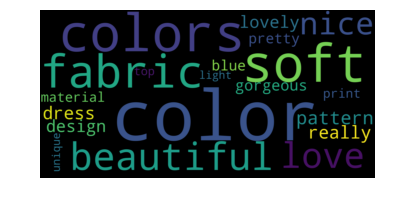

In [124]:
make_wordcloud(rev_sent_lrg_sample['Review Scrub'][rev_sent_lrg_sample['CW Cluster'] == inquiry_cluster], 20)

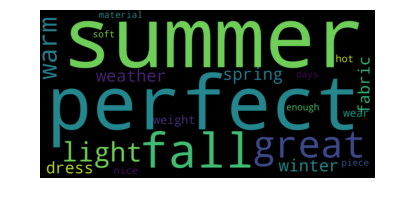

In [125]:
inquiry_cluster = 1430
make_wordcloud(rev_sent_lrg_sample['Review Scrub'][rev_sent_lrg_sample['CW Cluster'] == inquiry_cluster], 20)

In [126]:
rev_sent_lrg_sample['Review Sent'][rev_sent_lrg_sample['CW Cluster'] == inquiry_cluster][0:10]

7      i'm 5'9', 145 lbs,\nnice thick fabric, but not heavy, good for cool weather.                                                                  
220    This was a really nice, soft lightweight sweater, perfect for transitioning into fall.                                                        
276    the lining in particular is excellent- it is a soft mesh that prevents the dress from clinging, without adding bulk in the hot summer weather.
301    it's not going to be super warm, perfect for fall in colorado and warmer winter days.                                                         
381    perfect to wear as is or layer with cardigans, jackets and scarves in cooler weather.                                                         
420    Love the pattern and material (not thick) for spring and summer.                                                                              
448    perfect wait and not to giant, and perfect for year round work.                              

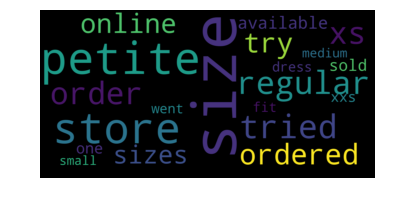

In [128]:
inquiry_cluster = 30
make_wordcloud(rev_sent_lrg_sample['Review Scrub'][rev_sent_lrg_sample['CW Cluster'] == inquiry_cluster], 20)

In [129]:
rev_sent_lrg_sample['Review Sent'][rev_sent_lrg_sample['CW Cluster'] == inquiry_cluster][0:10]

6       unfortunately the petite sizes sold out so i went with an xs.                                                                                                          
111     i bought them in regular size because the petite sold out so fast.                                                                                                     
510     i like that but did buy a petite instead of s regular to compensate (i swing both ways on oetite/regular sizing).                                                      
613     if i find my size in another store i can always exchange, but i couldn't leave the dress behind.                                                                       
688     i was going to try size zero, however as soon as i tried size 2, i rea                                                                                                 
697     imagine my surprise when i went to my local store and found it in both a small and a medium in white.. i tried t

## Some Results

**Threshold 0.8:**

- Number of nodes: 3461
- Number of edges: 38909
- Average degree: 22.4843
- 1 large cluster of 836 sentences

Next count is 401, 281 and a dozen or so to 20.

**Threshold 0.95:**

- Number of nodes: 60
- Number of edges: 39
- Average degree: 1.3000

Largest cluster had 7 sents, then a few on 3 then 2. Not big enough.

**Threshold 0.88, iterations 10:**

- Number of nodes: 1224
- Number of edges: 3022
- Average degree: 4.9379

Largest cluster had 126 sents, then a few in 70s then 35 and down to 20.

All of the above were too homogenous and I couldn't see the difference between clusters or commonlity within clusters.

**Increased Sample to 20k - Threshold 0.88, iterations 10:**

- Number of nodes: 7470
- Number of edges: 55686
- Average degree: 14.9092

Largest cluster had 2250 sents, then a few around 500 to 100 in the top 10.

Largest cluster is about size and seems coherent.

Wow! As shown, cluster are much more coherent and some quite suprising. Great result.

**Increased Sample to 30k - Threshold 0.88, iterations 10:**

- Number of nodes: 12329
- Number of edges: 120893
- Average degree: 19.6112

Largest cluster had 3200 sents, then a few around 900 to under 200 in the top 10.

Largest cluster is about size and fit but is not as coherent as smaller sample.

3rd cluster 700 about colour - vry similar to 20k

**Reflection**

This was an exciting project for me and this took text processing to a new level. I was able to analyze the data with some standard statistics applied to the various features and break the text down using the NLTK. Even at this level there are insights revealed that aren’t necessarily obvious.

I then ran the benchmark KMeans model and it was difficult to know how many clusters to set up. This is one of the downsides of that model.

Getting to grips with a graph model was a challenge but I feel like it clicked with me. Using cosine similarity was also a painstaking process to get clear in my head, but a greater understanding of vectors has resulted.

I was pleasantly surprised with the results and at times it felt slightly uncanny at
how well the sentences clustered. I hope the word clouds drepresented these well.

**Improvement**

The area of improvement I would focus on is the volume of sentences processed. Currently the model performed well with about 25% of the data but not so well at 60%. What would 100% be like? Would a higher threshold in the graph creation allow more nodes and reduce the edges? Would this result in better or worse clustering? How can one iteration of the model be measured more accurately against another?

I could rerun the benchmark model with more clusters which might produce better results.